<a href="https://colab.research.google.com/github/Pulsar-kkaturi/DL-Education/blob/master/VisionDL_Lecture/Lecture6_Classification_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

* Library Import

In [37]:
import os, matplotlib, csv, shutil, json, random
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from IPython.display import Image
import skimage
from skimage import io as skio
from skimage import transform as skit

### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

# scikit-learn
import sklearn.metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# GPU 확인
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. ResNet

### 1.1. Data Loading
* Kaggle Garbage Classification Dataset
  - Reference link: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification

In [11]:
# Dataset Download
!git clone https://github.com/Pulsar-kkaturi/DL-Education.git

fatal: destination path 'DL-Education' already exists and is not an empty directory.


In [12]:
# 데이터 압축 풀기
!tar -zxf ./DL-Education/dataset/garbage_cls_2d.tar.gz

In [13]:
data_path = './garbage_cls_2d'
label_list = list(sorted(os.listdir(data_path)))
print(label_list)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [14]:
# data number check
for c in label_list:
  cn = 0
  cls_path = os.path.join(data_path, c)
  for f in os.listdir(cls_path):
    cn += 1
  print(f'{c} number = {cn}')

cardboard number = 403
glass number = 501
metal number = 410
paper number = 594
plastic number = 482
trash number = 137


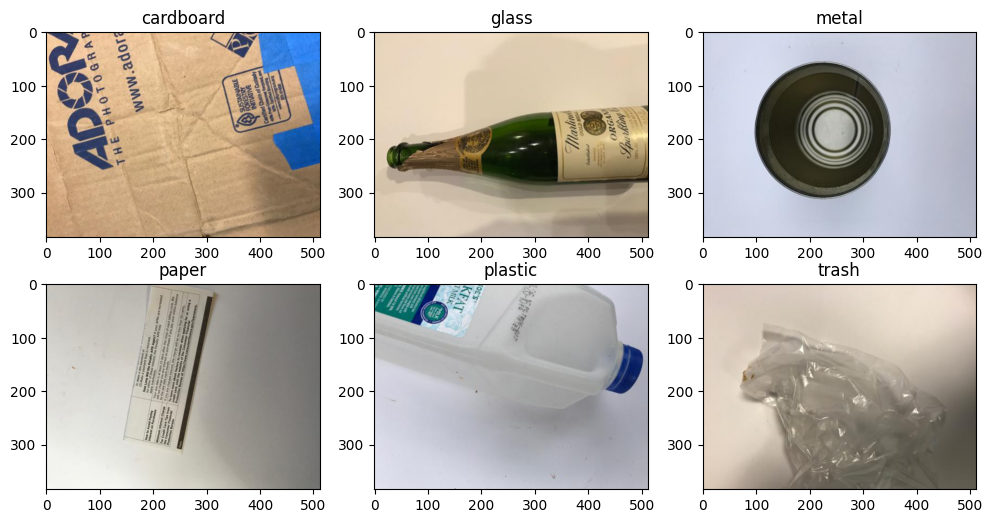

In [15]:
# Data visulization
plt.figure(figsize=(12,6))
for i, c in enumerate(label_list):
  cls_path = os.path.join(data_path, c)
  sam_path = os.path.join(cls_path, os.listdir(cls_path)[0])
  sam_arr = skio.imread(sam_path)
  plt.subplot(2,3,i+1)
  plt.title(c)
  plt.imshow(sam_arr)

### 1.2. Data Pre-processing

In [24]:
# one-hot encoding
for c in label_list:
  onehot = [0]*len(label_list)
  onehot[label_list.index(c)] = 1
  print(c, label_list.index(c), onehot)

cardboard 0 [1, 0, 0, 0, 0, 0]
glass 1 [0, 1, 0, 0, 0, 0]
metal 2 [0, 0, 1, 0, 0, 0]
paper 3 [0, 0, 0, 1, 0, 0]
plastic 4 [0, 0, 0, 0, 1, 0]
trash 5 [0, 0, 0, 0, 0, 1]


In [26]:
# Numpy array로 데이터 변환
data_dic, label_dic = {}, {}
for key in label_list:
  data_dic[key] = []
  label_dic[key] = []

for i, c in enumerate(label_list):
  cls_path = os.path.join(data_path, c)
  for f in sorted(os.listdir(cls_path)):
    file_path = os.path.join(cls_path, f)
    data_arr = skio.imread(file_path)
    onehot = [0]*len(label_list)
    onehot[label_list.index(c)] = 1
    data_dic[c].append(data_arr)
    label_dic[c].append(onehot)

cardboard: data_number = 403, label_number = 403, label show = [1, 0, 0, 0, 0, 0]
glass: data_number = 501, label_number = 501, label show = [0, 1, 0, 0, 0, 0]
metal: data_number = 410, label_number = 410, label show = [0, 0, 1, 0, 0, 0]
paper: data_number = 594, label_number = 594, label show = [0, 0, 0, 1, 0, 0]
plastic: data_number = 482, label_number = 482, label show = [0, 0, 0, 0, 1, 0]
trash: data_number = 137, label_number = 137, label show = [0, 0, 0, 0, 0, 1]


cardboard: data_number = 403, label_number = 403
glass: data_number = 501, label_number = 501
metal: data_number = 410, label_number = 410
paper: data_number = 594, label_number = 594
plastic: data_number = 482, label_number = 482
trash: data_number = 137, label_number = 137


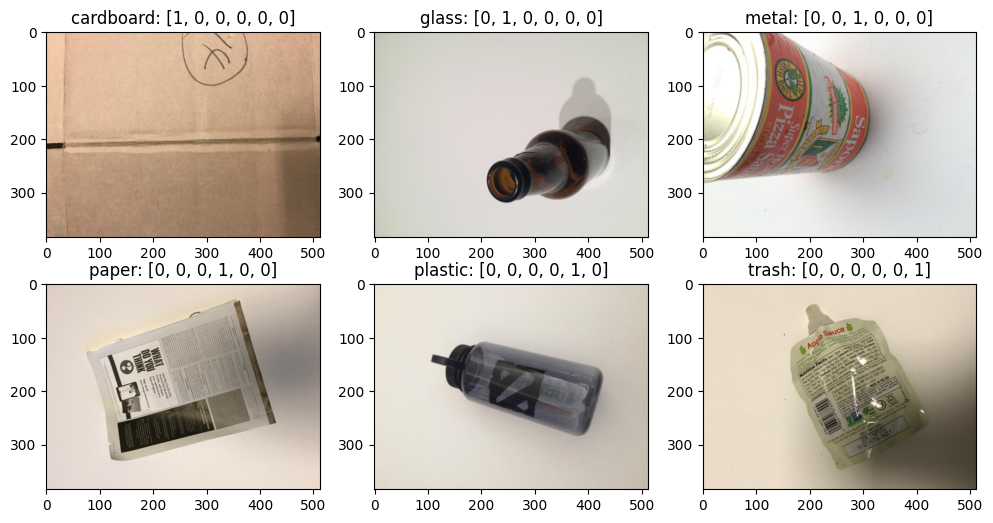

In [29]:
plt.figure(figsize=(12,6))
for i, k in enumerate(data_dic.keys()):
  print(f'{k}: data_number = {len(data_dic[k])}, label_number = {len(label_dic[k])}')
  plt.subplot(2,3,i+1)
  plt.title(f'{k}: {label_dic[k][0]}')
  plt.imshow(data_dic[k][0])

In [36]:
# Train-Validation-Test settig
val_num = 50
test_num = 5

train_x_list, train_y_list = [], []
val_x_list, val_y_list = [], []
test_x_list, test_y_list = [], []

for k in label_list:
  vn, tn = 0, 0
  for i, arr in enumerate(data_dic[k]):
    if tn < test_num:
      test_x_list.append(arr)
      test_y_list.append(label_dic[k][i])
      tn += 1
    elif vn < val_num:
      val_x_list.append(arr)
      val_y_list.append(label_dic[k][i])
      vn += 1
    else:
      train_x_list.append(arr)
      train_y_list.append(label_dic[k][i])

print(len(train_x_list), len(val_x_list), len(test_x_list))
print(len(train_y_list), len(val_y_list), len(test_y_list))

2197 300 30
2197 300 30


In [38]:
random.Random(0814).shuffle(train_x_list)
random.Random(0814).shuffle(train_y_list)
random.Random(0814).shuffle(val_x_list)
random.Random(0814).shuffle(val_y_list)
random.Random(0814).shuffle(test_x_list)
random.Random(0814).shuffle(test_y_list)

train_x = np.array(train_x_list, dtype=np.float32)
train_y = np.array(train_y_list, dtype=np.uint8)
val_x = np.array(val_x_list, dtype=np.float32)
val_y = np.array(val_y_list, dtype=np.uint8)
test_x = np.array(test_x_list, dtype=np.float32)
test_y = np.array(test_y_list, dtype=np.uint8)

print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)
print(test_x.shape, val_y.shape)

SyntaxError: ignored